In [197]:
import json
import random
from tqdm import tqdm
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import torch

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

# Что делать?
Где есть пометка # CODE писать код

[Полезный туториал](http://jalammar.github.io/illustrated-word2vec/)

# Загружаем данные
Они уже обработанные и токенизированные. Процесс можно посмотреть в тетрадке 1.1 Processing corpus

In [45]:
with open('data/processed_corpus.json', encoding='utf-8') as f:
    corpus = json.load(f)

In [46]:
len(corpus)

100000

In [47]:
for text in corpus[:5]:
    print(' '.join(text))

второй UNK год окончательно разочаровать решить податься альфабанк
вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит
притом ситуация решиться участие течение сутки заявить
мой ##число летний жизнь это самый неповоротливый работник банк который видеть
везде написать вклад принимать очередь это


# CBOW

In [48]:
sample_text = ['вопрос', 'почему', 'например', 'китайский', 'японский', 'UNK']

In [49]:
' '.join(sample_text)

'вопрос почему например китайский японский UNK'

# Реализуйте разделение предложения на примеры методом CBOW

In [50]:
def cbow_split(tokens, window, pad_token='PAD'):
    
    splits = []

    for n in range(len(tokens)):
        left_context = tokens[np.maximum(n - window, 0):n]
        left_context = ([pad_token] * (window - len(left_context))) + left_context

        central_word = tokens[n]

        right_context = tokens[n + 1:n + window + 1]
        right_context = right_context + ([pad_token] * (window - len(right_context)))

        splits.append((left_context, central_word, right_context))

    return splits

In [51]:
splits = cbow_split(sample_text, window=2)

In [52]:
for sample in splits:
    print('Левый контекст:', sample[0])
    print('Центральное слово:', sample[1])
    print('Правый контекст:', sample[2], end='\n\n')

Левый контекст: ['PAD', 'PAD']
Центральное слово: вопрос
Правый контекст: ['почему', 'например']

Левый контекст: ['PAD', 'вопрос']
Центральное слово: почему
Правый контекст: ['например', 'китайский']

Левый контекст: ['вопрос', 'почему']
Центральное слово: например
Правый контекст: ['китайский', 'японский']

Левый контекст: ['почему', 'например']
Центральное слово: китайский
Правый контекст: ['японский', 'UNK']

Левый контекст: ['например', 'китайский']
Центральное слово: японский
Правый контекст: ['UNK', 'PAD']

Левый контекст: ['китайский', 'японский']
Центральное слово: UNK
Правый контекст: ['PAD', 'PAD']



In [53]:
splits

[(['PAD', 'PAD'], 'вопрос', ['почему', 'например']),
 (['PAD', 'вопрос'], 'почему', ['например', 'китайский']),
 (['вопрос', 'почему'], 'например', ['китайский', 'японский']),
 (['почему', 'например'], 'китайский', ['японский', 'UNK']),
 (['например', 'китайский'], 'японский', ['UNK', 'PAD']),
 (['китайский', 'японский'], 'UNK', ['PAD', 'PAD'])]

# Expected

```python
[(['PAD', 'PAD'], 'вопрос', ['почему', 'например']),
 (['PAD', 'вопрос'], 'почему', ['например', 'китайский']),
 (['вопрос', 'почему'], 'например', ['китайский', 'японский']),
 (['почему', 'например'], 'китайский', ['японский', 'UNK']),
 (['например', 'китайский'], 'японский', ['UNK', 'PAD']),
 (['китайский', 'японский'], 'UNK', ['PAD', 'PAD'])]
```

In [54]:
cbow_split(sample_text, window=3)

[(['PAD', 'PAD', 'PAD'], 'вопрос', ['почему', 'например', 'китайский']),
 (['PAD', 'PAD', 'вопрос'], 'почему', ['например', 'китайский', 'японский']),
 (['PAD', 'вопрос', 'почему'], 'например', ['китайский', 'японский', 'UNK']),
 (['вопрос', 'почему', 'например'], 'китайский', ['японский', 'UNK', 'PAD']),
 (['почему', 'например', 'китайский'], 'японский', ['UNK', 'PAD', 'PAD']),
 (['например', 'китайский', 'японский'], 'UNK', ['PAD', 'PAD', 'PAD'])]

# Expected

```python
[(['PAD', 'PAD', 'PAD'], 'вопрос', ['почему', 'например', 'китайский']),
 (['PAD', 'PAD', 'вопрос'], 'почему', ['например', 'китайский', 'японский']),
 (['PAD', 'вопрос', 'почему'], 'например', ['китайский', 'японский', 'UNK']),
 (['вопрос', 'почему', 'например'], 'китайский', ['японский', 'UNK', 'PAD']),
 (['почему', 'например', 'китайский'], 'японский', ['UNK', 'PAD', 'PAD']),
 (['например', 'китайский', 'японский'], 'UNK', ['PAD', 'PAD', 'PAD'])]
```

# Skipgram

In [55]:
' '.join(sample_text)

'вопрос почему например китайский японский UNK'

# Реализуйте разделение предложения на примеры методом Skipgram

In [56]:
def skipgram_split(tokens, window):
    
    splits = []
    
    for n in range(len(tokens)):
        central = tokens[n]
        contexts = []
        for i in range(window, 0, -1):
            if n - i >= 0:
                context = tokens[n - i]
                contexts.append(context)
        for i in range(1, window + 1):
            if n + i < len(tokens):
                context = tokens[n + i]
                contexts.append(context)
        
        contexts = [(context, central) for context in contexts]
        
        splits.extend(contexts)
    
    return splits

In [57]:
splits = skipgram_split(sample_text, window=2)

In [58]:
for sample in splits:
    print('Контекст:', sample[0])
    print('Центральное слово:', sample[1], end='\n\n')

Контекст: почему
Центральное слово: вопрос

Контекст: например
Центральное слово: вопрос

Контекст: вопрос
Центральное слово: почему

Контекст: например
Центральное слово: почему

Контекст: китайский
Центральное слово: почему

Контекст: вопрос
Центральное слово: например

Контекст: почему
Центральное слово: например

Контекст: китайский
Центральное слово: например

Контекст: японский
Центральное слово: например

Контекст: почему
Центральное слово: китайский

Контекст: например
Центральное слово: китайский

Контекст: японский
Центральное слово: китайский

Контекст: UNK
Центральное слово: китайский

Контекст: например
Центральное слово: японский

Контекст: китайский
Центральное слово: японский

Контекст: UNK
Центральное слово: японский

Контекст: китайский
Центральное слово: UNK

Контекст: японский
Центральное слово: UNK



In [59]:
skipgram_split(sample_text, window=2)

[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [60]:
skipgram_split(sample_text, window=3)

[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('китайский', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('японский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('UNK', 'например'),
 ('вопрос', 'китайский'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('почему', 'японский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('например', 'UNK'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('китайский', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('японский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('UNK', 'например'),
 ('вопрос', 'китайский'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('почему', 'японский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('например', 'UNK'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [61]:
word2index = {}

for text in corpus:
    for token in text:
        if token not in word2index:
            word2index[token] = len(word2index)

In [62]:
len(word2index)

13076

In [63]:
word2index['UNK']

1

In [64]:
[word2index[tok] if tok in word2index else word2index['UNK'] for tok in 'мама мыть рама'.split()]

[1282, 8436, 1]

# Torch Dataset
В торче есть очень удобная читалка данных

In [67]:
from torch.utils.data import Dataset, DataLoader

In [68]:
# игрушечный датасет
# 121535 примера, 4 фичи, 3 класса
some_data_x = np.random.rand(121535, 4)
some_data_y = np.random.randint(3, size=(121535,))

In [69]:
# соверешенно игрушечный, просто цифры
some_data_x[:10]

array([[0.50777404, 0.07091353, 0.84930852, 0.89357883],
       [0.05430067, 0.01109899, 0.53375627, 0.52355795],
       [0.55268474, 0.12881931, 0.92240003, 0.207429  ],
       [0.97989267, 0.64405238, 0.66567397, 0.74621057],
       [0.23779513, 0.75301111, 0.75595218, 0.03811309],
       [0.0075315 , 0.36358409, 0.75416665, 0.4858208 ],
       [0.48224331, 0.80986717, 0.46996286, 0.52650389],
       [0.28080106, 0.74122563, 0.37756358, 0.81160275],
       [0.68245777, 0.81434785, 0.06108886, 0.75516474],
       [0.22580226, 0.04455522, 0.14479698, 0.04000564]])

In [70]:
some_data_y

array([1, 2, 2, ..., 2, 1, 2])

In [71]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        return self.data_x[idx], self.data_y[idx]

In [72]:
some_dataset = ToyDataset(some_data_x, some_data_y)

In [73]:
some_dataset[5], some_dataset[467]

((array([0.0075315 , 0.36358409, 0.75416665, 0.4858208 ]), 0),
 (array([0.70372918, 0.31497732, 0.18650827, 0.50343561]), 2))

In [74]:
some_loader = DataLoader(some_dataset, batch_size=16, shuffle=True)

In [75]:
for x, y in some_loader:
    break
    
len(x), x

(16,
 tensor([[0.9447, 0.1938, 0.5409, 0.3133],
         [0.0949, 0.5963, 0.8163, 0.2648],
         [0.9329, 0.2660, 0.6360, 0.0961],
         [0.3127, 0.0909, 0.2547, 0.9951],
         [0.3662, 0.0801, 0.7024, 0.2415],
         [0.6724, 0.3750, 0.8262, 0.4967],
         [0.0320, 0.0864, 0.5820, 0.6222],
         [0.2661, 0.0533, 0.3414, 0.7262],
         [0.3069, 0.7093, 0.1105, 0.2554],
         [0.6589, 0.1031, 0.9137, 0.9022],
         [0.0187, 0.5978, 0.1796, 0.3526],
         [0.4952, 0.6081, 0.0928, 0.2575],
         [0.1790, 0.3406, 0.1086, 0.1482],
         [0.7644, 0.8042, 0.2631, 0.5189],
         [0.5212, 0.4623, 0.0355, 0.6337],
         [0.2601, 0.6542, 0.0868, 0.6004]], dtype=torch.float64))

In [76]:
for x, y in some_loader:
    pass

len(x)

15

In [77]:
# почему 13?
# потому что количество наших данных нацело не делится на 16
# и поэтому последний батч меньше 16-ти
len(some_dataset) % 16

15

# А зачем?

In [78]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    @staticmethod
    def add_pow_features(x, n=2):
        
        return np.concatenate([x, x ** n]) 
    
    @staticmethod
    def add_log_features(x):
        
        return np.concatenate([x, np.log(x)]) 
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        x = self.data_x[idx]
        
        # внутри датасета мы можем делать все что угодно с нашими данными
        # например выше определим функции, которые добавляют степенные фичи
        x = self.add_pow_features(x, n=2)
        x = self.add_pow_features(x, n=3)
        # и еще возьмем логарифмические фичи
        x = self.add_log_features(x)
        
        y = self.data_y[idx]
        
        return x, y

In [79]:
toy_dataset = ToyDataset(some_data_x, some_data_y)

In [80]:
toy_loader = DataLoader(dataset=toy_dataset, batch_size=128)

In [81]:
for x, y in toy_loader:
    break

In [82]:
x.shape

torch.Size([128, 32])

In [83]:
# заметим, что мы сразу получаем торчовый формат данных
x

tensor([[ 5.0777e-01,  7.0914e-02,  8.4931e-01,  ..., -1.5878e+01,
         -9.8000e-01, -6.7512e-01],
        [ 5.4301e-02,  1.1099e-02,  5.3376e-01,  ..., -2.7005e+01,
         -3.7669e+00, -3.8826e+00],
        [ 5.5268e-01,  1.2882e-01,  9.2240e-01,  ..., -1.2296e+01,
         -4.8466e-01, -9.4378e+00],
        ...,
        [ 4.0506e-01,  5.0478e-01,  2.2383e-01,  ..., -4.1018e+00,
         -8.9812e+00, -2.4510e+00],
        [ 9.8824e-02,  7.9219e-01,  2.2339e-01,  ..., -1.3978e+00,
         -8.9930e+00, -1.0159e+01],
        [ 8.7873e-01,  8.4847e-01,  2.8134e-01,  ..., -9.8589e-01,
         -7.6091e+00, -5.3121e-01]], dtype=torch.float64)

In [84]:
y

tensor([1, 2, 2, 2, 1, 0, 0, 2, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 2, 1, 1, 0, 1, 2,
        2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 0, 2, 2, 1, 0, 0, 1, 1, 1, 0, 2, 1, 2, 0,
        0, 0, 1, 0, 0, 2, 2, 2, 0, 1, 2, 0, 1, 2, 0, 0, 0, 2, 2, 2, 0, 1, 2, 2,
        1, 1, 1, 1, 2, 0, 1, 0, 0, 2, 0, 1, 2, 0, 0, 2, 2, 1, 0, 1, 2, 1, 2, 1,
        0, 0, 0, 2, 1, 0, 1, 0, 1, 1, 2, 1, 0, 2, 1, 2, 0, 0, 0, 0, 0, 2, 0, 1,
        2, 2, 1, 0, 0, 2, 1, 0], dtype=torch.int32)

# Если вы ничего здесь не понимаете, то вернитесь в конец первой домашки, там все объясняется

In [85]:
model = torch.nn.Sequential(torch.nn.Linear(32, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 8),
                            torch.nn.ReLU(),
                            torch.nn.Linear(8, 3))

criterion = torch.nn.CrossEntropyLoss()

In [90]:
with torch.no_grad():

    prediction = model(x.float())

    loss = criterion(prediction, y.type(torch.LongTensor))
    
loss.item()

1.1182994842529297

# Боевые датасеты

In [91]:
class CBOWDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 pad_token='PAD',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.pad_token = pad_token
        self.pad_index = len(self.word2index)

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):

        splits = []

        for n in range(len(tokenized_text)):
            left_context = tokenized_text[np.maximum(n - self.window, 0):n]
            left_context = ([self.pad_index] * (self.window - len(left_context))) + left_context

            central_word = tokenized_text[n]

            right_context = tokenized_text[n + 1:n + self.window + 1]
            right_context = right_context + ([self.pad_index] * (self.window - len(right_context)))

            splits.append((left_context + right_context, central_word))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            cbow_examples = self._split_function(indexed_text)

            self.data.extend(cbow_examples)

    def __getitem__(self, idx):

        context, central_word = self.data[idx]

        context = torch.Tensor(context).long()

        return context, central_word

# Мы будем учить модель Skipgram
Реализуйте читалку данных

In [138]:
class SkipgramDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 collect_verbose=True):
        
        self.corpus = corpus
        self.word2index = word2index
        self.window = window
        self.unk_token = unk_token
        self.unk_index = word2index[unk_token]
        self.collect_verbose = collect_verbose
        
        self.data = []
        
        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):
        
        # CODE
        
        # вставить здесь функцию, которые вы писали раньше
        splits = []
        
        for n in range(len(tokenized_text)):
            central = tokenized_text[n]
            contexts = []
            for i in range(self.window, 0, -1):
                if n - i >= 0:
                    context = tokenized_text[n - i]
                    contexts.append(context)
            for i in range(1, self.window + 1):
                if n + i < len(tokenized_text):
                    context = tokenized_text[n + i]
                    contexts.append(context)

            contexts = [(context, central) for context in contexts]

            splits.extend(contexts)

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            skipgram_examples = self._split_function(indexed_text)

            self.data.extend(skipgram_examples)

    def __getitem__(self, idx):
        
        # CODE
        context, central_word = self.data[idx]
        
        return context, central_word

In [139]:
# можете положить SkipgramDataset в отдельный файлик, например word2vec_utils и относительным импортом достать его 
#from .word2vec_utils import SkipgramDataset

In [140]:
dataset = SkipgramDataset(corpus, word2index)

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 51713.51it/s]


In [141]:
BATCH_SIZE = 512

In [142]:
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

In [144]:
for x, y in dataset_loader:
    break

In [145]:
x[:5]

tensor([  16, 1235, 6207,   51,  593])

In [146]:
y[:5]

tensor([ 214, 3176,  697, 4039,  277])

In [147]:
x.shape, y.shape

(torch.Size([512]), torch.Size([512]))

In [148]:
class CBOW(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, pad_index):
        
        super().__init__()
        
        if pad_index > 0:
            vocab_size += 1
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim,
                                               padding_idx=pad_index)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
        
    def forward(self, x):
        
        x = self.in_embedding(x).sum(dim=-2)
        x = self.out_embedding(x)
        
        return x

# Мы будем учить модель Skipgram
Реализуйте ее

In [174]:
# CODE
class SkipGram(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        
        super().__init__()
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, 
                                             bias=False)
    
    def forward(self, x):
        
        x = self.in_embedding(x)
        x = self.out_embedding(x)
        
        return x

In [175]:
#from word2vec_utils import SkipGram

In [176]:
# размерность эмбеддинга
# маленькая, чтобы мы могли недолго поучить ворд2век и увидеть результаты
EMBEDDING_DIM = 20

In [177]:
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)

In [178]:
with torch.no_grad():
    pred = model(x)

pred.shape

torch.Size([512, 13076])

In [179]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

# aka loss function
criterion = torch.nn.CrossEntropyLoss()

# Допишите обучалку

In [180]:
from tqdm.notebook import tqdm

In [181]:
epochs = 3

losses = []

for n_epoch in range(epochs):
    
    try:

        progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

        for x, y in dataset_loader:

            # CODE
            pred = model(x)
            
            loss = criterion(pred, y.long())
            
            # CODE
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            
            progress_bar.set_postfix(loss=np.mean(losses[-100:]))

            progress_bar.update(x.shape[0])

        progress_bar.close()

    except KeyboardInterrupt:

        progress_bar.close()
        break

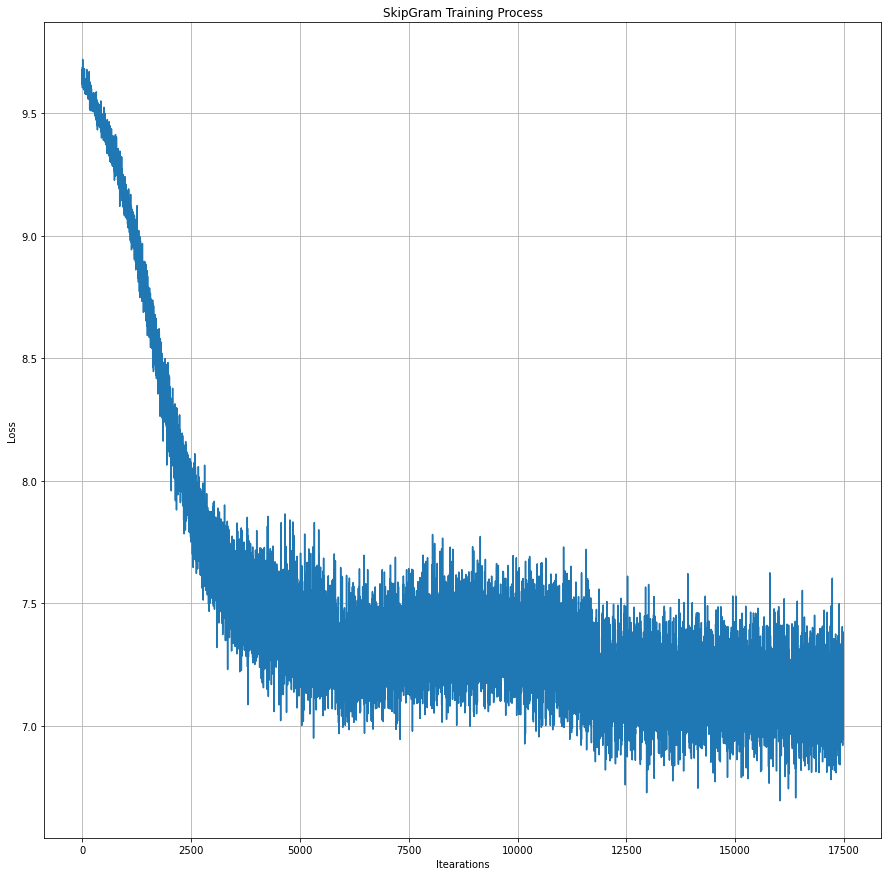

In [182]:
plt.title('SkipGram Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

In [183]:
# проверка, что хоть что-то выучилось
assert np.mean(losses[-1000:]) < 7.5

In [184]:
embedding_matrix = model.in_embedding.weight.detach()

In [185]:
def cos_sim(embedding_matrix, token2id, word1, word2):
    
    i1 = token2id[word1]
    i2 = token2id[word2]
    
    v1, v2 = embedding_matrix[i1], embedding_matrix[i2]
    
    v1_n = v1.div(v1.norm(keepdim=True))
    v2_n = v2.div(v2.norm(keepdim=True))
    
    similarity = torch.dot(v1_n, v2_n).item()
    
    return similarity

# Косинусная близость
От 0 до 1, где 0 - вектора абсолютно разные, где 1 - идентичные.

In [186]:
cos_sim(embedding_matrix, word2index, 'день', 'месяц')

C:\Users\VADIK\anaconda3\lib\site-packages\torch\functional.py:1276: UserWarning: torch.norm is deprecated and may be removed in a future PyTorch release. Use torch.linalg.norm instead.
  warnings.warn((


0.7539281845092773

In [187]:
cos_sim(embedding_matrix, word2index, 'минута', 'месяц')

0.822855532169342

In [188]:
cos_sim(embedding_matrix, word2index, 'сотрудник', 'сотрудница')

0.6358329057693481

In [189]:
cos_sim(embedding_matrix, word2index, 'вклад', 'перевод')

0.6524100303649902

In [190]:
random_word = random.choice(list(word2index.keys()))
sim = cos_sim(embedding_matrix, word2index, 'день', random_word)
'Косинусная близость слова "день" к случайному выбраному слову "{}" равна {:.3f}'.format(random_word, sim)

'Косинусная близость слова "день" к случайному выбраному слову "пускай" равна 0.194'

In [191]:
freq = {}

for text in corpus:
    for token in text:
        if token in freq:
            freq[token] += 1
        else:
            freq[token] = 1

In [192]:
sorted_freq = [(k, freq[k]) for k in sorted(freq, key=freq.get, reverse=True)]
top_sorted_freq = sorted_freq[0:200]

In [193]:
tsne = TSNE(n_components=2, init='pca', random_state=42, verbose=2)
reduced = tsne.fit_transform(embedding_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13076 samples in 0.064s...
[t-SNE] Computed neighbors for 13076 samples in 6.617s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13076
[t-SNE] Computed conditional probabilities for sample 2000 / 13076
[t-SNE] Computed conditional probabilities for sample 3000 / 13076
[t-SNE] Computed conditional probabilities for sample 4000 / 13076
[t-SNE] Computed conditional probabilities for sample 5000 / 13076
[t-SNE] Computed conditional probabilities for sample 6000 / 13076
[t-SNE] Computed conditional probabilities for sample 7000 / 13076
[t-SNE] Computed conditional probabilities for sample 8000 / 13076
[t-SNE] Computed conditional probabilities for sample 9000 / 13076
[t-SNE] Computed conditional probabilities for sample 10000 / 13076
[t-SNE] Computed conditional probabilities for sample 11000 / 13076
[t-SNE] Computed conditional probabilities for sample 12000 / 13076
[t-SNE] Computed conditional probabilities for sam

In [194]:
top_words = [a for a,_ in top_sorted_freq]

In [195]:
inds = [word2index[word] for word in top_words]
x_coords = [coords[0] for coords in reduced[inds]]
y_coords = [coords[1] for coords in reduced[inds]]

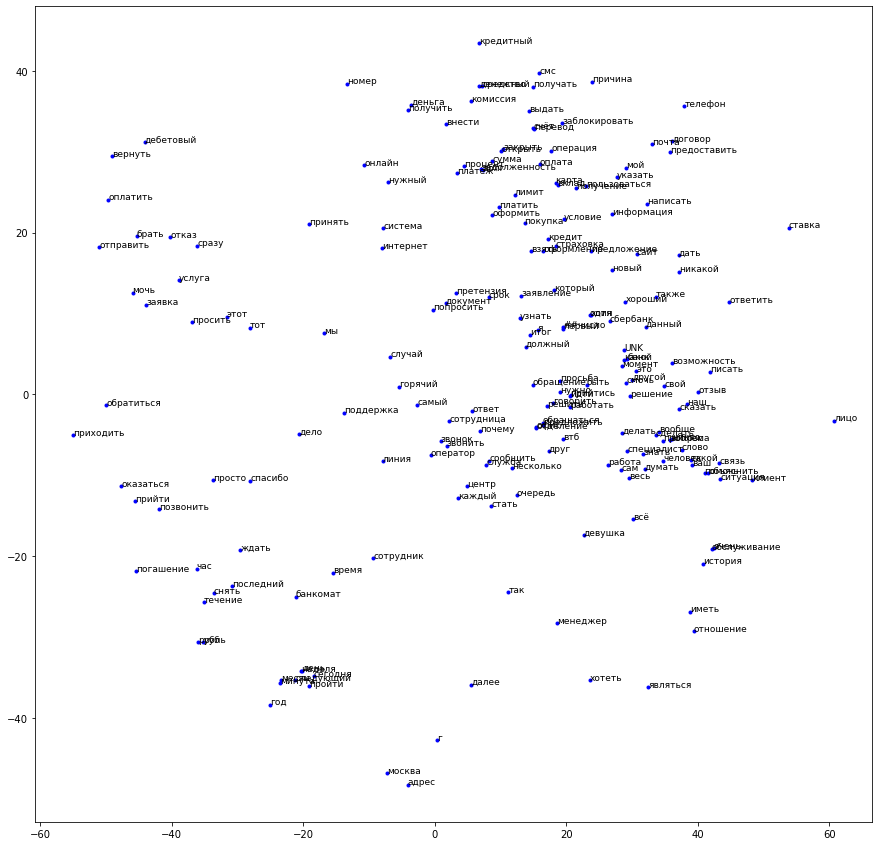

In [196]:
for (x, y, word) in zip(x_coords, y_coords, top_words):
    plt.scatter(x, y, marker='.', color='blue')
    plt.text(x+0.01, y+0.01, word, fontsize=9)
plt.show()

# Оценка
1. Вы добрались сюда и все работает, значит уже получили 7 баллов.
2. 8 баллов - Взяли корпус для оценка качества эмбеддингов [здесь](https://rusvectores.org/static/testsets/ru_simlex965_tagged.tsv). Описание к нему [здесь](https://arxiv.org/pdf/1801.06407.pdf). Его английская версия для понимания, того что же это такое [тут](https://fh295.github.io/simlex.html). Если в кратце - он похож а гугл аналогии, просто иначе составлен. Определили качество своих эмбеддингов. Как качество измерить? Можете все значения отнормировать (привести к 1) и затем считать MSE между тем что у вас и что в оригинале.
3. 9 баллов - Поставили эксперименты, поменяли любые параметры, хоть корпус увеличили или как то почистили. Показали метрики до и после. После должно быть лучше, иначе это все еще 8 баллов.
4. 10 баллов - удивили своим подходом (или просто удивили) пока делили на 9 баллов

In [200]:
embs = pd.read_csv('ru_simlex965_tagged.tsv', sep='\t')

In [201]:
embs

,# Word1,Word2,Average Score
0,авария_NOUN,бедствие_NOUN,6.15
1,август_NOUN,месяц_NOUN,2.85
2,авиация_NOUN,полет_NOUN,6.77
3,автомобиль_NOUN,гудок_NOUN,1.85
4,автомобиль_NOUN,автострада_NOUN,1.23
...,...,...,...
960,яблоко_NOUN,солнце_NOUN,0.15
961,ядро_NOUN,пушка_NOUN,2.77
962,язык_NOUN,горло_NOUN,1.38
963,ярд_NOUN,дюйм_NOUN,2.62


In [204]:
embs['New Score'] = np.nan
vocab = word2index.keys()
for num, row in embs.iterrows():
    word1 = row['# Word1'].split('_')[0]
    word2 = row['Word2'].split('_')[0]
    if (word1 in vocab)and(word2 in vocab):
        score = cos_sim(embedding_matrix, word2index, word1, word2)
        embs.loc[num, 'New Score'] = score

C:\Users\VADIK\anaconda3\lib\site-packages\torch\functional.py:1276: UserWarning: torch.norm is deprecated and may be removed in a future PyTorch release. Use torch.linalg.norm instead.
  warnings.warn((


In [208]:
embs = embs[embs['New Score'].isna() == False].reset_index(drop=True)

In [219]:
max_average = embs['Average Score'].max()
min_average = embs['Average Score'].min()
embs['Average Normalized'] = (abs(embs['Average Score']) - min_average)/(max_average - min_average)

In [220]:
max_new = embs['New Score'].max()
min_new = embs['New Score'].min()
embs['New Normalized'] = (abs(embs['New Score']) - min_average)/(max_average - min_average)

In [227]:
embs['MSE'] = (embs['Average Normalized'] - embs['New Normalized'])**2

In [229]:
embs['MSE'].sum() / embs.shape[0]

0.17970881424816193